In [ ]:
import os
from glob import glob

In [ ]:
!pip install earthpy
!pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.4 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches, colors
import seaborn as sns
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em


In [ ]:
sns.set_style('white')
sns.set(font_scale=1.5)

In [ ]:
data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics','data'))

Extracted output to /root/earth-analytics/data/cold-springs-fire/.


In [ ]:
def open_clean_band(band_path, crop_layer=None):
  if crop_layer is not None:
    try:
      clip_bound = crop_layer.geometry
      cleaned_band = rxr.open_rasterio(band_path, masked=True).rio.clip(clip_bound, from_disk=True)
    except Exception as err:
      print("Oops, I need a geodataframe object for this to work")
      print(err)
  else:
    cleaned_band = rxr.open_rasterio(band_path, masked=True).squeeze()
  return cleaned_band

In [ ]:
def process_bands(paths, crop_layer=None, stack=False):
  all_bands=[]
  for i, aband in enumerate(paths):
    cleaned = open_clean_band(aband, crop_layer)
    cleaned["band"] = i+1
    all_bands.append(cleaned)
  if stack:
    print("Stacking bands")
    stacked_bands = xr.concat(all_bands, dim="band")
    return stacked_bands
  else:
    print("Returning all bands")
    return all_bands

In [ ]:
landsat_dirpath_pre = os.path.join("cold-springs-fire",
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604",
                                   "crop",
                                   "*band[2-5]*.tif")

landsat_paths_pre = sorted(glob(landsat_dirpath_pre))

landsat_pre = process_bands(landsat_paths_pre, stack=True)
landsat_pre

Stacking bands


<xarray.DataArray (band: 4, y: 177, x: 246)> Size: 697kB
array([[[ 443.,  456.,  446., ...,  213.,  251.,  293.],
        [ 408.,  420.,  436., ...,  226.,  272.,  332.],
        [ 356.,  375.,  373., ...,  261.,  329.,  383.],
        ...,
        [ 407.,  427.,  428., ...,  306.,  273.,  216.],
        [ 545.,  552.,  580., ...,  307.,  315.,  252.],
        [ 350.,  221.,  233., ...,  320.,  348.,  315.]],

       [[ 635.,  641.,  629., ...,  360.,  397.,  454.],
        [ 601.,  617.,  620., ...,  380.,  418.,  509.],
        [ 587.,  600.,  573., ...,  431.,  513.,  603.],
        ...,
        [ 679.,  742.,  729., ...,  493.,  482.,  459.],
        [ 816.,  827.,  824., ...,  461.,  502.,  485.],
        [ 526.,  388.,  364., ...,  463.,  501.,  512.]],

       [[ 625.,  671.,  651., ...,  265.,  307.,  340.],
        [ 568.,  620.,  627., ...,  309.,  354.,  431.],
        [ 513.,  510.,  515., ...,  362.,  464.,  565.],
        ...,
        [ 725.,  834.,  864., ...,  485.,  467.,  457.],
        [1031.,  864.,  844., ...,  438.,  457.,  429.],
        [ 525.,  432.,  411., ...,  465.,  472.,  451.]],

       [[2080., 1942., 1950., ..., 1748., 1802., 2135.],
        [2300., 2045., 1939., ..., 1716., 1783., 2131.],
        [2582., 2443., 2347., ..., 1836., 2002., 2241.],
        ...,
        [2076., 1993., 2145., ..., 1914., 2066., 2166.],
        [1910., 1899., 1962., ..., 1787., 2038., 2300.],
        [1633., 1611., 1738., ..., 1714., 1848., 2194.]]], dtype=float32)
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * y            (y) float64 1kB 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
  * x            (x) float64 2kB 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  8481
    STATISTICS_MEAN:     664.90340361031
    STATISTICS_MINIMUM:  -767
    STATISTICS_STDDEV:   1197.873301452
    scale_factor:        1.0
    add_offset:          0.0

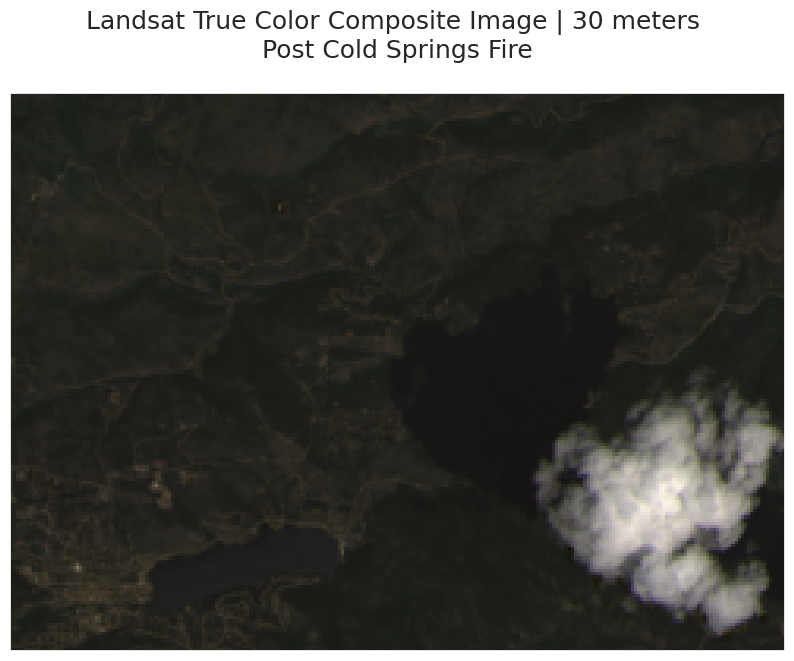

In [ ]:
ep.plot_rgb(landsat_pre.values,
            rgb=[2, 1, 0],
            title="Landsat True Color Composite Image | 30 meters \n Post Cold Springs Fire \n ")

plt.show()

In [ ]:
landsat_pre_cl_path = os.path.join("cold-springs-fire",
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604",
                                   "crop",
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

landsat_qa = rxr.open_rasterio(landsat_pre_cl_path).squeeze()

high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence


landsat_pre_cl_free = landsat_pre.where(~landsat_qa.isin(all_masked_values))

In [ ]:

high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence
all_masked_values

[328,
 392,
 840,
 904,
 1350,
 352,
 368,
 416,
 432,
 480,
 864,
 880,
 928,
 944,
 992,
 480,
 992]

In [ ]:
# Create the cloud mask
cl_mask = landsat_qa.isin(all_masked_values)
np.unique(cl_mask)

array([False,  True])

/usr/local/lib/python3.12/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


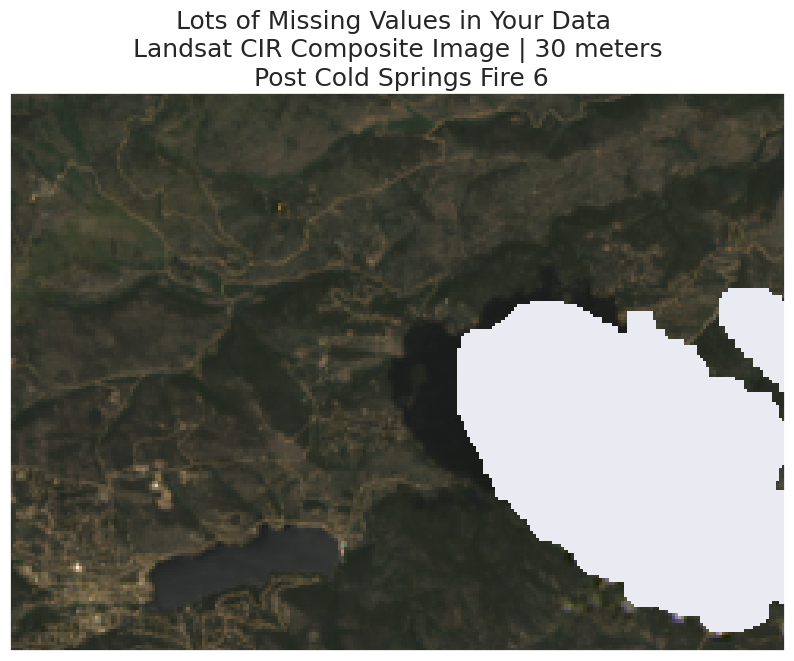

In [ ]:
ep.plot_rgb(landsat_pre_cl_free,
            rgb=[2, 1, 0],
            title="Lots of Missing Values in Your Data \n Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire 6")
plt.show()

/tmp/ipython-input-3191181194.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('tab20b', 2))


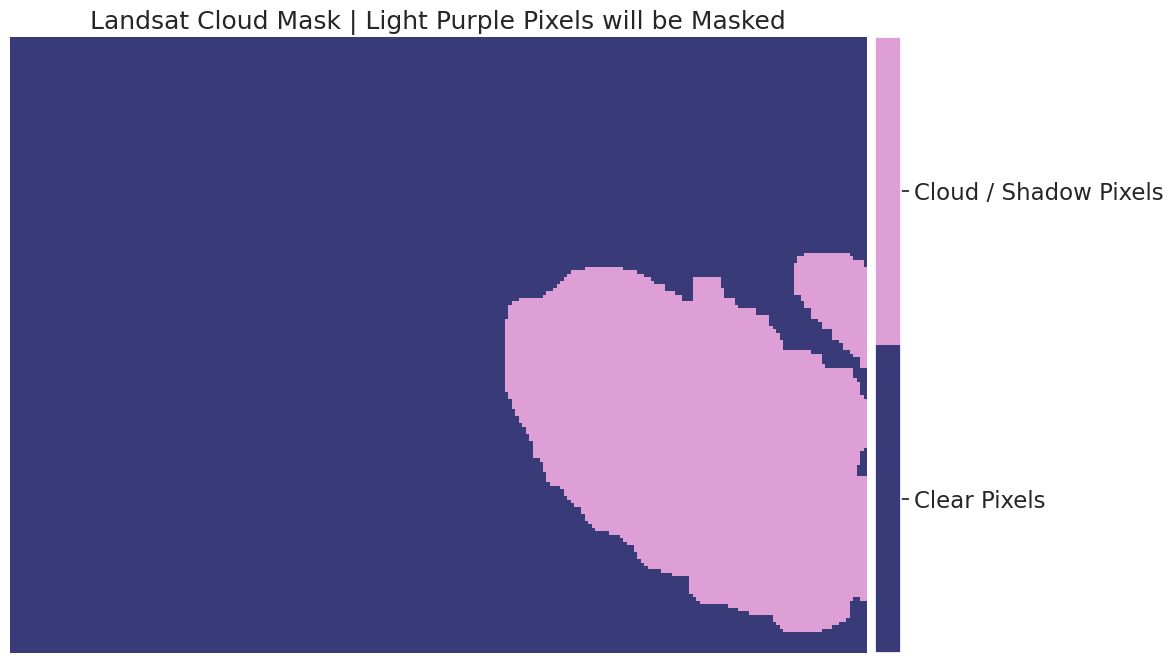

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(cl_mask,
               cmap=plt.cm.get_cmap('tab20b', 2))

cbar = ep.colorbar(im)
cbar.set_ticks((0.25, .75))
cbar.ax.set_yticklabels(["Clear Pixels", "Cloud / Shadow Pixels"])

ax.set_title("Landsat Cloud Mask | Light Purple Pixels will be Masked")
ax.set_axis_off()

plt.show()

In [ ]:
landsat_pre_cl_free = landsat_pre.where(~cl_mask)

In [ ]:
landsat_pre_cl_free = landsat_pre.where(~landsat_qa.isin(all_masked_values))

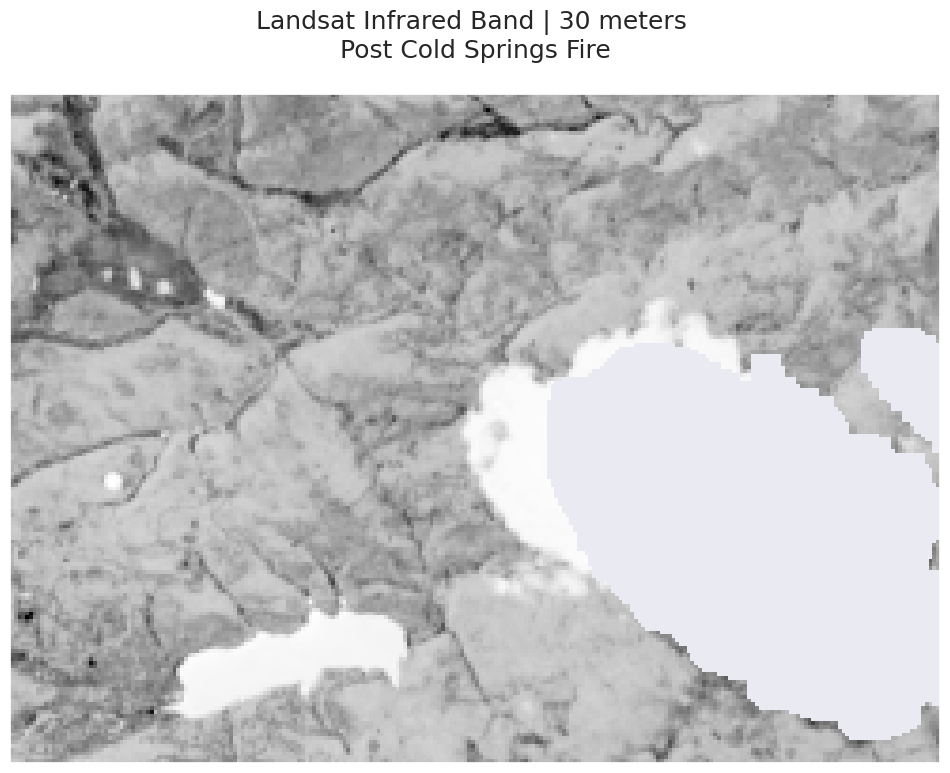

In [ ]:
ep.plot_bands(landsat_pre_cl_free[3],
              cmap="Greys",
              title="Landsat Infrared Band | 30 meters \n Post Cold Springs Fire \n ",
              cbar=False)
plt.show()

/usr/local/lib/python3.12/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


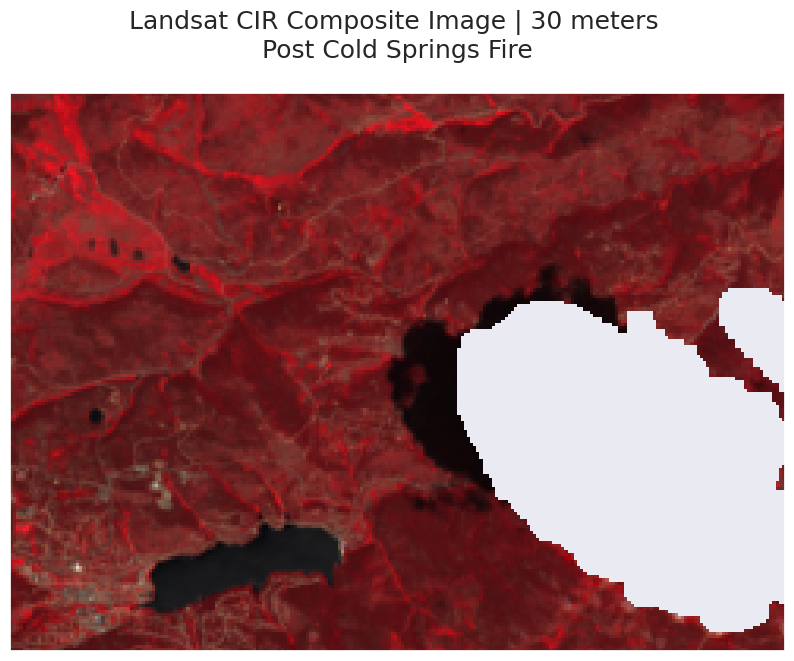

In [ ]:
ep.plot_rgb(landsat_pre_cl_free,
            rgb=[3, 2, 1],
            title="Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire \n")
plt.show()

In [ ]:
from shapely.geometry import box
import geopandas as gpd


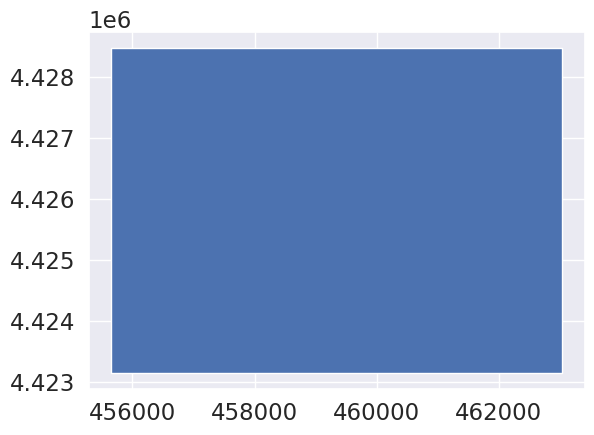

In [ ]:
# Create bounds object to clip the cloud free data
landsat_pre_cloud_ext_bds = landsat_pre.rio.bounds()

df = {'id': [1],
      'geometry': box(*landsat_pre.rio.bounds())}
clip_gdf = gpd.GeoDataFrame(df, crs=landsat_pre.rio.crs)
clip_gdf.plot()
plt.show()

In [ ]:
data_2 = et.data.get_data('cs-test-landsat')

cloud_free_path = os.path.join("cs-test-landsat",
                                "*band[2-4]*.tif")

# Redefine the process_bands function with the fix
def process_bands(paths, crop_layer=None, stack=False):
  all_bands=[]
  for i, aband in enumerate(paths):
    cleaned = open_clean_band(aband, crop_layer)
    # Ensure the 'band' dimension is squeezed if it exists and has size 1
    # This assumes each 'aband' represents a single spectral band.
    if 'band' in cleaned.dims and cleaned.sizes['band'] == 1:
        cleaned = cleaned.squeeze('band')
    cleaned["band"] = i+1
    all_bands.append(cleaned)
  if stack:
    print("Stacking bands")
    stacked_bands = xr.concat(all_bands, dim="band")
    return stacked_bands
  else:
    print("Returning all bands")
    return all_bands

landsat_paths_pre_cloud_free = sorted(glob(cloud_free_path))
landsat_pre_cloud_free = process_bands(landsat_paths_pre_cloud_free,
                                       stack=True,
                                       crop_layer=clip_gdf)

landsat_pre_cloud_free


Extracted output to /root/earth-analytics/data/cs-test-landsat/.
Stacking bands


<xarray.DataArray (band: 3, y: 177, x: 246)> Size: 1MB
array([[[590., 629., 636., ..., 218., 234., 283.],
        [546., 580., 598., ..., 248., 270., 314.],
        [484., 503., 506., ..., 284., 325., 348.],
        ...,
        [434., 431., 438., ..., 290., 291., 303.],
        [441., 490., 478., ..., 292., 312., 313.],
        [340., 278., 297., ..., 299., 334., 337.]],

       [[781., 808., 828., ..., 461., 485., 535.],
        [748., 795., 807., ..., 491., 519., 574.],
        [727., 754., 743., ..., 535., 590., 627.],
        ...,
        [722., 724., 722., ..., 550., 554., 569.],
        [706., 777., 756., ..., 546., 577., 591.],
        [578., 484., 500., ..., 548., 590., 607.]],

       [[770., 839., 845., ..., 331., 363., 412.],
        [730., 793., 812., ..., 379., 421., 479.],
        [657., 692., 691., ..., 441., 522., 573.],
        ...,
        [697., 789., 797., ..., 497., 486., 505.],
        [837., 788., 802., ..., 476., 505., 508.],
        [542., 477., 465., ..., 510., 536., 536.]]])
Coordinates:
  * band         (band) int64 24B 1 2 3
  * y            (y) float64 1kB 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
  * x            (x) float64 2kB 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
    spatial_ref  int64 8B 0
Attributes:
    Band_1:         band 2 surface reflectance
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      band 2 surface reflectance

In [ ]:
mask = landsat_pre_cl_free.isnull()


common_bands = landsat_pre_cloud_free["band"]
mask_common_bands = mask.sel(band=common_bands)
landsat_pre_cl_free_common_bands = landsat_pre_cl_free.sel(band=common_bands)


landsat_pre_clouds_filled_common = xr.where(mask_common_bands,
                                            landsat_pre_cloud_free,
                                            landsat_pre_cl_free_common_bands)


landsat_pre_clouds_filled = landsat_pre_cl_free.copy(deep=True)


landsat_pre_clouds_filled.loc[{"band": common_bands.values}] = landsat_pre_clouds_filled_common

landsat_pre_clouds_filled

<xarray.DataArray (band: 4, y: 177, x: 246)> Size: 697kB
array([[[ 443.,  456.,  446., ...,  213.,  251.,  293.],
        [ 408.,  420.,  436., ...,  226.,  272.,  332.],
        [ 356.,  375.,  373., ...,  261.,  329.,  383.],
        ...,
        [ 407.,  427.,  428., ...,  306.,  273.,  216.],
        [ 545.,  552.,  580., ...,  307.,  315.,  252.],
        [ 350.,  221.,  233., ...,  320.,  348.,  315.]],

       [[ 635.,  641.,  629., ...,  360.,  397.,  454.],
        [ 601.,  617.,  620., ...,  380.,  418.,  509.],
        [ 587.,  600.,  573., ...,  431.,  513.,  603.],
        ...,
        [ 679.,  742.,  729., ...,  493.,  482.,  459.],
        [ 816.,  827.,  824., ...,  461.,  502.,  485.],
        [ 526.,  388.,  364., ...,  463.,  501.,  512.]],

       [[ 625.,  671.,  651., ...,  265.,  307.,  340.],
        [ 568.,  620.,  627., ...,  309.,  354.,  431.],
        [ 513.,  510.,  515., ...,  362.,  464.,  565.],
        ...,
        [ 725.,  834.,  864., ...,  485.,  467.,  457.],
        [1031.,  864.,  844., ...,  438.,  457.,  429.],
        [ 525.,  432.,  411., ...,  465.,  472.,  451.]],

       [[2080., 1942., 1950., ..., 1748., 1802., 2135.],
        [2300., 2045., 1939., ..., 1716., 1783., 2131.],
        [2582., 2443., 2347., ..., 1836., 2002., 2241.],
        ...,
        [2076., 1993., 2145., ..., 1914., 2066., 2166.],
        [1910., 1899., 1962., ..., 1787., 2038., 2300.],
        [1633., 1611., 1738., ..., 1714., 1848., 2194.]]], dtype=float32)
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * y            (y) float64 1kB 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
  * x            (x) float64 2kB 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  8481
    STATISTICS_MEAN:     664.90340361031
    STATISTICS_MINIMUM:  -767
    STATISTICS_STDDEV:   1197.873301452
    scale_factor:        1.0
    add_offset:          0.0

In [ ]:
landsat_no_clouds_bds = landsat_pre_cloud_free.rio.bounds()
landsat_pre_cloud_ext_bds = landsat_pre.rio.bounds()
print("The cloud free data bounds are:", landsat_no_clouds_bds)
print("The original cloud covered data bounds are:",  landsat_pre_cl_free.rio.bounds())
print("Are the bounds the same?", landsat_no_clouds_bds == landsat_pre_cloud_ext_bds)

The cloud free data bounds are: (455655.0, 4423155.0, 463035.0, 4428465.0)
The original cloud covered data bounds are: (455655.0, 4423155.0, 463035.0, 4428465.0)
Are the bounds the same? True


In [ ]:
# Create polygons from the bounds
cloud_free_scene_bds = box(*landsat_no_clouds_bds)
cloudy_scene_bds = box(*landsat_pre_cloud_ext_bds)


cloud_free_scene_bds.intersects(cloudy_scene_bds)

True

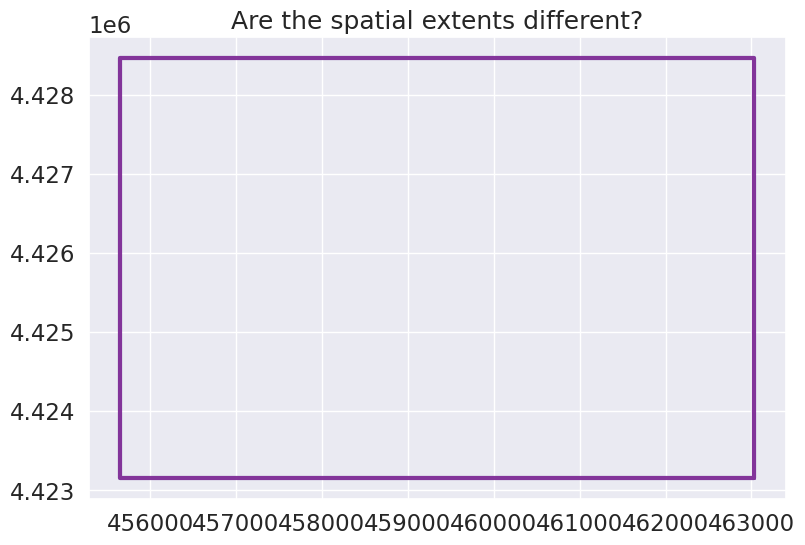

In [ ]:
x, y = cloud_free_scene_bds.exterior.xy
x1, y1 = cloudy_scene_bds.exterior.xy

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(x, y, color='#6699cc', alpha=0.7,
        linewidth=3, solid_capstyle='round', zorder=2)

ax.plot(x1, y1, color='purple', alpha=0.7,
        linewidth=3, solid_capstyle='round', zorder=2)

ax.set_title('Are the spatial extents different?')

plt.show()

In [ ]:
landsat_pre.rio.crs == landsat_pre_cloud_free.rio.crs

True

In [ ]:
landsat_pre.shape == landsat_pre_cloud_free.shape

False

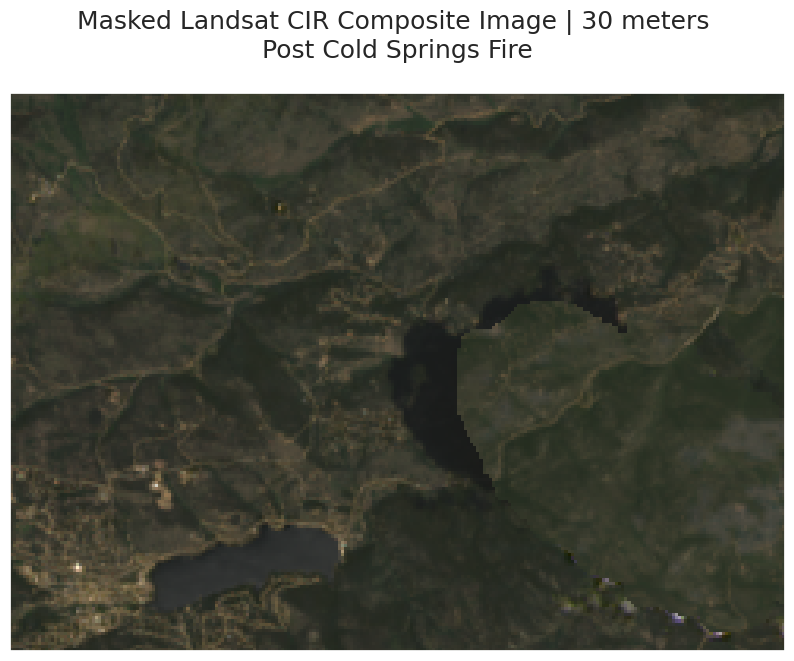

In [ ]:

ep.plot_rgb(landsat_pre_clouds_filled.values,
            rgb=[2, 1, 0],
            title="Masked Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire \n")
plt.show()